# Dans ce Notebook, on se propose de regarder les différentes surfaces cultivées de chaque culture déclarée par les agriculteurs en mode "réalisé".

# Partie générique

### Imports

In [1]:

# en cas de problème d'import, installer le module manquant en décommentant la ligne suivante et remplacant par le nom du module
# !pip install [MODULE_MANQUANT]

import numpy as np
import pandas
from collections import defaultdict, Counter
from pathlib import Path
from itertools import chain
from tqdm import tqdm
import re
import matplotlib.pyplot as plt


### Chemin des données exportées de Datagrosyst [A ADAPTER]

In [2]:

# les fichiers csv sont dans ce dossier
DATA_FOLDER_PATH = '/home/administrateur/Documents/datagrosyst' # [A ADAPTER]


### Définitions utiles

In [3]:

data_folder = Path(DATA_FOLDER_PATH)

def load_df(nom):
    """
        vient charger une dataframe avec le fichier Datagrosyst du bon nom
    """
    return pandas.read_csv(data_folder / (nom+'.csv'), index_col='id')


### Définition des tables à charger [A ADAPTER]

In [4]:

data_names = {}

data_names['context']            = ['sdc', 'parcelle', 'zone', 'synthetise', 'sole_realise',] # [A ADAPTER]
data_names['intervention']       = ['noeuds_realise',] # [A ADAPTER]
data_names['intrant_&_culture']  = ['culture', 'semence', 'composant_culture',] # [A ADAPTER]
data_names['modele_decisionnel'] = [] # [A ADAPTER]
data_names['bilan_de_campagne']  = [] # [A ADAPTER]
data_names['performance']        = [] # [A ADAPTER]
data_names['referentiel']        = ['espece',] # [A ADAPTER]


### Charment des données

In [5]:

# Loader des dataframes
df = {}

for data_name in chain(*data_names.values()):
    df[data_name] = load_df(data_name)


# Etude de la répartition des espèces cultivées (systèmes réalisés)

### Traitement

In [6]:

compoant_culture_by_culture_id = df['composant_culture'].groupby(['culture_id'])
cultures_sans_composant_associe = []
soles_avec_culture_indefinie = []

surfaces_occupees = defaultdict(float)

for sole_realise in tqdm(df['sole_realise'].itertuples(), desc='Parcours des soles en realise', total=len(df['sole_realise'])):
    # zone
    zone = df['zone'].loc[sole_realise.zone_id]
    surface_zone = zone['surface']
    
    # espece
    culture = df['culture'].loc[sole_realise.culture_id] # millesimé
    # culture_code = culture['code'] # non millesimé (peut représenter différentes cultures réelles selon les années)
    if not sole_realise.culture_id in compoant_culture_by_culture_id.groups:
        soles_avec_culture_indefinie.append(sole_realise)
        cultures_sans_composant_associe.append(culture)
        surfaces_occupees['INDEFINI'] += surface_zone
        continue

    composants_culture = compoant_culture_by_culture_id.get_group(sole_realise.culture_id)
    for composant_culture in composants_culture.itertuples(index=False):
        espece = df['espece'].loc[composant_culture.espece_id]
        nom_espece = espece['libelle_espece_botanique']
        proportion_espece = composant_culture.surface_relative
        if proportion_espece != proportion_espece:
            proportion_espece = 100/len(composants_culture)

        surfaces_occupees[nom_espece] += surface_zone * proportion_espece / 100

# on trie par especes les plus utilisees
surfaces_occupees = dict(sorted(surfaces_occupees.items(), key=lambda item: item[1], reverse=True))

print()
for nom_espece, surface_occupee in surfaces_occupees.items():
    print(f'L espèce "{nom_espece:^30}" a été cultivée sur {surface_occupee:7.0f} Ha [{(100*surface_occupee / sum(surfaces_occupees.values())):2.1f} %]')


Parcours des soles en realise:   0%|          | 0/112372 [00:00<?, ?it/s]

Parcours des soles en realise: 100%|██████████| 112372/112372 [00:41<00:00, 2740.15it/s]


L espèce "          Blé tendre          " a été cultivée sur  189949 Ha [30.4 %]
L espèce "             Maïs             " a été cultivée sur   85631 Ha [13.7 %]
L espèce "             Orge             " a été cultivée sur   79328 Ha [12.7 %]
L espèce "            Colza             " a été cultivée sur   61110 Ha [9.8 %]
L espèce "           Prairie            " a été cultivée sur   32179 Ha [5.2 %]
L espèce "          Betterave           " a été cultivée sur   21193 Ha [3.4 %]
L espèce "          Tournesol           " a été cultivée sur   20061 Ha [3.2 %]
L espèce "             Pois             " a été cultivée sur   18190 Ha [2.9 %]
L espèce "           Luzerne            " a été cultivée sur   13550 Ha [2.2 %]
L espèce "             Soja             " a été cultivée sur   10703 Ha [1.7 %]
L espèce "           Fèverole           " a été cultivée sur    9125 Ha [1.5 %]
L espèce "        Pomme de terre        " a été cultivée sur    8447 Ha [1.4 %]
L espèce "          Triticale       

### Graphique

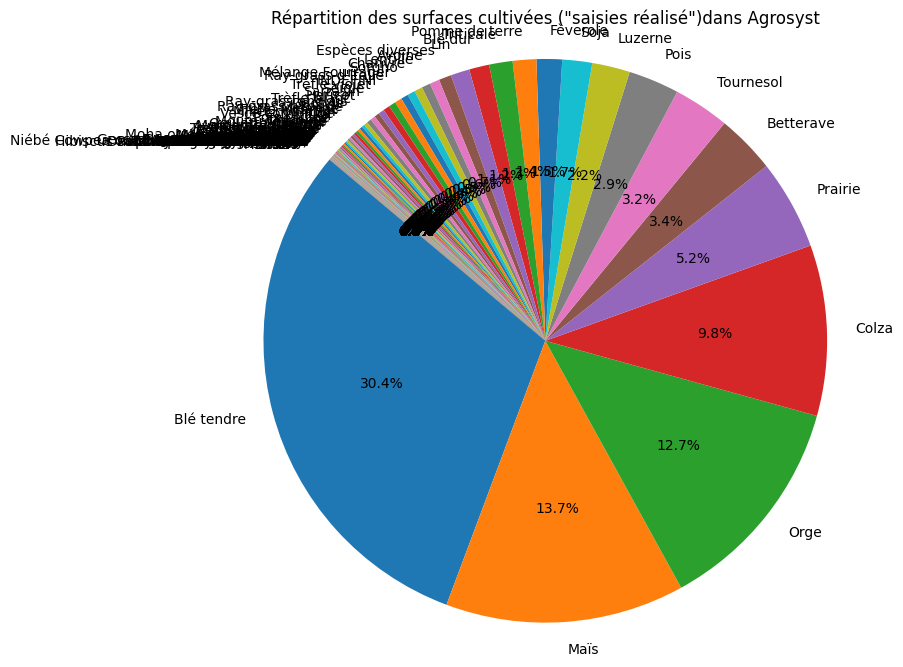

In [7]:

# Diagramme camembert
plt.figure(figsize=(8, 8)) # Taille du diagramme
plt.pie(surfaces_occupees.values(), labels=surfaces_occupees.keys(), autopct='%1.1f%%', startangle=140)

plt.title('Répartition des surfaces cultivées ("saisies réalisé")dans Agrosyst')
plt.axis('equal') # Permet d'avoir un diagramme circulaire plutôt qu'elliptique
plt.show()


# Pour aller plus loin

### => On essaie d'identifier les cultures renseignées sans especes associées

In [8]:

soles_avec_culture_indefinie = pandas.DataFrame(soles_avec_culture_indefinie)
cultures_sans_composant_associe = pandas.DataFrame(cultures_sans_composant_associe)

noms_saisis_aggreges = Counter(cultures_sans_composant_associe['nom'])

print(f'Il y a {len(cultures_sans_composant_associe)} cultures saisies sans composants associés.\n')
print('Les noms (champ libre) renseignés sont :\n')

for element, count in noms_saisis_aggreges.most_common():
    print(f"   {element:<25}: {count} saisies")


Il y a 787 cultures saisies sans composants associés.

Les noms (champ libre) renseignés sont :

   Jachère                  : 84 saisies
   Jachère > 5 ans          : 47 saisies
   Jachère de 6 ans ou plus : 39 saisies
   Blé                      : 33 saisies
   PRAIRIE TEMPORAIRE       : 31 saisies
   Vide sanitaire           : 24 saisies
   Espèces diverses         : 14 saisies
   Prairie temporaire       : 13 saisies
   prairie temporaire       : 13 saisies
   Tournesol                : 12 saisies
   Soja                     : 12 saisies
   Colza                    : 11 saisies
   Plante de service        : 10 saisies
   plante de service        : 10 saisies
   Méteil de printemps      : 9 saisies
   MAIS GRAIN               : 9 saisies
   sainfoin                 : 9 saisies
   Moutarde                 : 7 saisies
   Féverole                 : 7 saisies
   Prairie permanente       : 7 saisies
   Prairie Temporaire       : 7 saisies
   CROTALAIRE               : 6 saisies
   maïs e

In [9]:

# Rend sous forme d'expression régulière une forme du mot plus générique
def to_regex(mot):
    regex_mot = '['+mot[0].upper()+mot[0].lower()+']'+mot[1:] + '|' + mot.upper()
    regex_mot = '(e|é|è)'.join(re.split('e|é|è', regex_mot))
    regex_mot = '(E|É|È)'.join(re.split('E|É|È', regex_mot))
    return regex_mot


#### Tentative de rechercher les cultures orphelines au sein des noms d'especes existantes

In [10]:

trouve, toujours_pas, abandonne = {}, {}, []

for nom_saisi, count in noms_saisis_aggreges.items():

    regex_nom_saisi = to_regex(nom_saisi)

    noms_especes_matchantes = df['espece'].loc[df['espece']['libelle_espece_botanique'].str.match(regex_nom_saisi), 'libelle_espece_botanique'].unique()

    if len(noms_especes_matchantes)==0:
        toujours_pas[nom_saisi] = count
    elif len(noms_especes_matchantes)==1:
        trouve[nom_saisi] = noms_especes_matchantes[0]
    else:
        # on regarde les noms d'especes qui ont matché
        print(f'Candidats pour la saisie "{nom_saisi}" : ', noms_especes_matchantes)
        # on attribue à l'espèce dont le nom match parfaitement si il existe
        exact_match = False
        for nom_espece_matchante in noms_especes_matchantes:
            if re.match('^'+regex_nom_saisi+'$', nom_espece_matchante):
                trouve[nom_saisi] = nom_espece_matchante
                exact_match = True
                break # c'est la seule, on a pas deux noms d'espèces égaux à Majuscules près
        if not exact_match:
            # on attribue la culture au nom d'espèce le plus populaire dans la "ferme DEPHY"
            nom_espece_matchante = noms_especes_matchantes[np.argmax([surfaces_occupees.get(nom_espece_matchante, 0) for nom_espece_matchante in noms_especes_matchantes])]
            if nom_espece_matchante in surfaces_occupees:
                trouve[nom_saisi] = nom_espece_matchante
            else:
                # on ne va pas ajouter aléatoirement un des espèces si aucune ne matche complètement et qu'aucune n'est utilisée d'autre part par la "ferme DEPHY"
                abandonne.append(nom_saisi)
print('\n***************************************************************************')
print(f'***** Sur les {len(noms_saisis_aggreges)} noms saisis sans especes associees, on en a retrouvé {len(trouve)}')
print('***************************************************************************')


Candidats pour la saisie "Luzerne" :  ['Luzerne tropicale' 'Luzerne']
Candidats pour la saisie "Sarrasin" :  ['Sarrasin de Tartarie' 'Sarrasin']
Candidats pour la saisie "seigle" :  ['Seigle forestier' 'Seigle']
Candidats pour la saisie "Blé" :  ['Blé dur' 'Blé tendre']
Candidats pour la saisie "Moutarde" :  ['Moutarde épinard' "Moutarde d'abyssinie" 'Moutarde brune'
 'Moutarde noire' 'Moutarde blanche']
Candidats pour la saisie "Pois" :  ['Pois' "Pois d'Angole" 'Pois sabre' 'Pois zye noir' 'Pois doux'
 'Pois chiche']
Candidats pour la saisie "Soja" :  ['Soja pérenne' 'Soja']
Candidats pour la saisie "sainfoin" :  ["Sainfoin d'Espagne" 'Sainfoin']
Candidats pour la saisie "Ail" :  ['Ail des ours' 'Ail rocambole' 'Ail']
Candidats pour la saisie "Sainfoin" :  ["Sainfoin d'Espagne" 'Sainfoin']
Candidats pour la saisie "soja" :  ['Soja pérenne' 'Soja']
Candidats pour la saisie "Tomate" :  ['Tomate' "Tomate d'amazonie "]
Candidats pour la saisie "Avoine" :  ['Avoine brésilienne' 'Avoine byz

#### Tentative de rechercher les noms d'especes existantes au sein des cultures orphelines

In [11]:

toujours_toujours_pas = {}

for nom_saisi, count in toujours_pas.items():

    noms_especes_matchantes = []
    for nom_espece in df['espece']['libelle_espece_botanique'].unique():
        regex_nom_espece = to_regex(nom_espece)
        if re.match(regex_nom_espece, nom_saisi) is not None:
            noms_especes_matchantes.append(nom_espece)

    if len(noms_especes_matchantes)==0:
        toujours_toujours_pas[nom_saisi] = count
    elif len(noms_especes_matchantes)==1:
        trouve[nom_saisi] = noms_especes_matchantes[0]
    else:
        # on regarde les noms d'especes qui ont matché
        print(f'\nCandidats pour la saisie "{nom_saisi}" : ', noms_especes_matchantes)
        # on attribue à l'espèce dont le nom match parfaitement si il existe
        exact_match = False
        for nom_espece_matchante in noms_especes_matchantes:
            regex_nom_espece = to_regex(nom_espece_matchante)
            if re.match('^'+regex_nom_espece+'$', nom_saisi):
                trouve[nom_saisi] = nom_espece_matchante
                exact_match = True
                break # c'est la seule, on a pas deux noms d'espèces égaux à Majuscules près
        if not exact_match:
            # on attribue la culture au nom d'espèce le plus populaire dans la "ferme DEPHY"
            nom_espece_matchante = noms_especes_matchantes[np.argmax([surfaces_occupees.get(nom_espece_matchante, 0) for nom_espece_matchante in noms_especes_matchantes])]
            if nom_espece_matchante in surfaces_occupees:
                trouve[nom_saisi] = nom_espece_matchante
            else:
                # on ne va pas ajouter aléatoirement un des espèces si aucune ne matche complètement et qu'aucune n'est utilisée d'autre part par la "ferme DEPHY"
                abandonne.append(nom_saisi)

print('\n***************************************************************************')
print(f'***** Sur les {len(noms_saisis_aggreges)} noms saisis sans especes associees, on en a retrouvé {len(trouve)}')
print('***************************************************************************')



Candidats pour la saisie "FEVEROLES" :  ['Fèverole', 'Fève']

Candidats pour la saisie "FEVEROLE d'hiver" :  ['Fèverole', 'Fève']

***************************************************************************
***** Sur les 191 noms saisis sans especes associees, on en a retrouvé 109
***************************************************************************


### Inclusion des espèces nouvellement retrouvées au calcul des surfaces respectives

In [12]:

# On réattribue pour le calcul des surfaces cultivees

surfaces_occupees['INDEFINI'] = 0

for sole_realise in tqdm(soles_avec_culture_indefinie.itertuples(), desc='Parcours des soles avec cultures non linkees a une espece', total=len(soles_avec_culture_indefinie)):
    # zone
    zone = df['zone'].loc[sole_realise.zone_id]
    surface_zone = zone['surface']
    
    # espece
    culture = df['culture'].loc[sole_realise.culture_id]
    if culture['nom'] in trouve:
        nom_espece = trouve[culture['nom']]
    else:
        nom_espece = 'INDEFINI'
    if isinstance(nom_espece, list): # TODO : pour avoir une liste ici, il faut s'atteler à repérer les mélanges d'espèces dans les noms (pas fait)
        for nom_espece_seule in nom_espece:
            proportion_espece = 100/len(nom_espece)
            surfaces_occupees[nom_espece_seule] = surfaces_occupees.get(nom_espece, 0) + surface_zone * proportion_espece / 100
    else:
        surfaces_occupees[nom_espece] = surfaces_occupees.get(nom_espece, 0) + surface_zone

# on trie par especes les plus utilisees
surfaces_occupees = dict(sorted(surfaces_occupees.items(), key=lambda item: item[1], reverse=True))

print()
for nom_espece, surface_occupee in surfaces_occupees.items():
    print(f'L espèce "{nom_espece:^30}" a été cultivée sur {surface_occupee:7.0f} Ha [{(100*surface_occupee / sum(surfaces_occupees.values())):2.1f} %]')


Parcours des soles avec cultures non linkees a une espece: 100%|██████████| 787/787 [00:00<00:00, 16284.66it/s]


L espèce "          Blé tendre          " a été cultivée sur  189981 Ha [30.4 %]
L espèce "             Maïs             " a été cultivée sur   85688 Ha [13.7 %]
L espèce "             Orge             " a été cultivée sur   79615 Ha [12.7 %]
L espèce "            Colza             " a été cultivée sur   61251 Ha [9.8 %]
L espèce "           Prairie            " a été cultivée sur   32395 Ha [5.2 %]
L espèce "          Betterave           " a été cultivée sur   21193 Ha [3.4 %]
L espèce "          Tournesol           " a été cultivée sur   20132 Ha [3.2 %]
L espèce "             Pois             " a été cultivée sur   18268 Ha [2.9 %]
L espèce "           Luzerne            " a été cultivée sur   13551 Ha [2.2 %]
L espèce "             Soja             " a été cultivée sur   10729 Ha [1.7 %]
L espèce "           Fèverole           " a été cultivée sur    9170 Ha [1.5 %]
L espèce "        Pomme de terre        " a été cultivée sur    8447 Ha [1.4 %]
L espèce "          Triticale       

### Graphique mis à jour

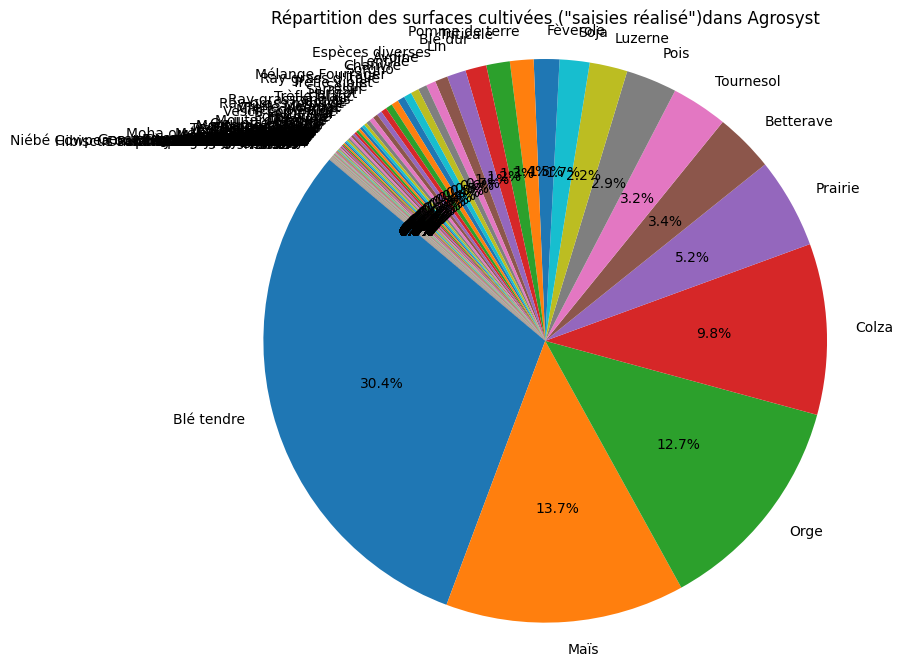

In [15]:

# Diagramme camembert
plt.figure(figsize=(8, 8)) # Taille du diagramme
plt.pie(surfaces_occupees.values(), labels=surfaces_occupees.keys(), autopct='%1.1f%%', startangle=140)

plt.title('Répartition des surfaces cultivées ("saisies réalisé")dans Agrosyst')
plt.axis('equal') # Permet d'avoir un diagramme circulaire plutôt qu'elliptique
plt.show()


# Pour aller un peu plus loin

###  => 4 métacatégories de cultures non liées à des espèces expliquant beaucoup de saisies restantes

In [13]:

print(f"Les {len(toujours_toujours_pas)} cultures toujours pas captées au sein d'un nom d'espèce botanique sont :")
dict(sorted(toujours_toujours_pas.items(), key=lambda item: item[1], reverse=True))


Les 82 cultures toujours pas captées au sein d'un nom d'espèce botanique sont :


{'Jachère': 84,
 'Jachère > 5 ans': 47,
 'Jachère de 6 ans ou plus': 39,
 'Vide sanitaire': 24,
 'Plante de service': 10,
 'plante de service': 10,
 'Méteil de printemps': 9,
 'MAIS GRAIN': 9,
 'CROTALAIRE': 6,
 'Eleusine': 6,
 'Alysse': 6,
 'Blette': 6,
 'OP': 6,
 'Jachère et gel melifere': 6,
 'Jachère 6 ans ou plus ou temporaire': 5,
 'Espèce diverse': 5,
 'Friche': 5,
 'Jachère floristique de 5 ans ou moins': 4,
 'Haie endémique': 4,
 'PT (PT)': 4,
 'MAIS FOURRAGE': 4,
 'SONGE GRISE': 4,
 'Jachère permanente': 4,
 'calebasse': 4,
 'PT': 3,
 'Jachère en légumineuses': 3,
 'Jachère en graminées': 3,
 'Salade': 3,
 'Culture dérobée': 2,
 'RGI + Trefle': 2,
 "ray grass d'italie": 2,
 'Citronnelle': 2,
 'jachère': 2,
 'RGA': 2,
 'crotalaire': 2,
 'DAE Maïs': 2,
 'Précédent fictif': 2,
 'zone enherbée': 2,
 'Vétiver': 2,
 'autres cépages': 2,
 'Trèfle pur': 2,
 'Friche agricole': 2,
 'Citrouille péi et butternut': 2,
 "Blé d'oeillette": 2,
 'Parcours': 2,
 'Méteil': 2,
 'PDS AROMATES': 2

In [14]:


familles_culture_orpheline = {
    'Jachère': [r".*[Jj]ach(e|é|è)res?|.*JACH(E|É|È)RES?",], 
    'Vide sanitaire': [r"[Vv]ides?( |_|-)[Ss]anitaires?|VIDES?( |_|-)SANITAIRES?",], 
    'Plante de service': [r"[Pp]lante de service",], 
    'Friche': [r".*[Ff]riches?|.*FRICHES?",], 
    # 'Prairie temporaire': [r"[Pp]rairies?( |_|-)[Tt]emporaires?|PRAIRIES?( |_|-)TEMPORAIRES?",], 
    # 'Prairie permanente': [r"[Pp]rairies?( |_|-)[Pp]ermanentes?|PRAIRIES?( |_|-)PERMANENTES?",], 
    # 'Espèces diverses': [r"Espèces? diverses?",], 
} # etc

def classif_culture_sans_reference(nom_saisi):
    
    for famille, textes_possibles in familles_culture_orpheline.items():
        for texte_possible in textes_possibles:
            correspondance = re.match(texte_possible, nom_saisi)
            if correspondance:
                return famille
    return None


retrouvees = {}
combien_retrouvees = 0
toujours_toujours_toujours_pas = {}

for nom_saisi, count in toujours_toujours_pas.items():
    famille_trouvee = classif_culture_sans_reference(nom_saisi)
    if famille_trouvee is None:
        toujours_toujours_toujours_pas[nom_saisi] = count
    else:
        retrouvees[nom_saisi] = famille_trouvee
        combien_retrouvees += count

print(f'Retrouvées sous les familles proposées [{len(retrouvees)} noms ({combien_retrouvees} saisies)]:')
for culture_orpheline, famille in sorted(retrouvees.items(), key=lambda item: item[1], reverse=True):
    print(f'   {culture_orpheline} --> {famille}')
print()
print(f'Reste [{len(toujours_toujours_toujours_pas)} noms ({sum(toujours_toujours_toujours_pas.values())} saisies)]:')
for culture_orpheline, nombre in sorted(toujours_toujours_toujours_pas.items(), key=lambda item: item[1], reverse=True):
    print(f'   {culture_orpheline}: {nombre} saisies')


Retrouvées sous les familles proposées [18 noms (251 saisies)]:
   Vide sanitaire --> Vide sanitaire
   Plante de service --> Plante de service
   plante de service --> Plante de service
   JACHERE   --> Jachère
   Jachère --> Jachère
   Jachère 6 ans ou plus ou temporaire --> Jachère
   Jachère floristique de 5 ans ou moins --> Jachère
   jachère --> Jachère
   Jachère de 6 ans ou plus --> Jachère
   Jachère > 5 ans --> Jachère
   Jachère en légumineuses --> Jachère
   Jachère en graminées --> Jachère
   Jachère et gel melifere --> Jachère
   Jachère permanente --> Jachère
   Jachère depuis 2010 --> Jachère
   Jachères --> Jachère
   Friche --> Friche
   Friche agricole --> Friche

Reste [64 noms (147 saisies)]:
   Méteil de printemps: 9 saisies
   MAIS GRAIN: 9 saisies
   CROTALAIRE: 6 saisies
   Eleusine: 6 saisies
   Alysse: 6 saisies
   Blette: 6 saisies
   OP: 6 saisies
   Espèce diverse: 5 saisies
   Haie endémique: 4 saisies
   PT (PT): 4 saisies
   MAIS FOURRAGE: 4 saisies
   

On voit donc que la plupart des saisies de culture où l'agent n'a pas renseigné d'espèce(s) associée(s), on peut tout de même retrouver un nom d'espèce parmi les noms d'espèces botanique existants; et dans les cas où on ne peut toujours pas, on a pu classer la majeure partie des saisies dans un nombre de catégories restreint (4).